## Summary: Edelweiss C and its Error

This notebook is a copy of edelweiss_C_systematicErrors_allParameters.ipynb, but using more accurate calculations for the NR and ER bands.

## Band Widths
Edelweiss parametrizes their band widths for all detectors (see eq'ns 9, 10, and 11 from the above paper).  

$$\sigma_{Q\gamma}(E_R) = \frac{1 + V/\epsilon}{E_R}\sqrt{\sigma_I^2 + \sigma_H^2}$$

$$\sigma_{Qn}(E_R) = \sqrt{C^2 + \frac{1}{E^2_R} \left( \left(1+\frac{V}{\epsilon}\langle Q_n\rangle\right)^2\sigma_I^2 + \left( 1+\frac{V}{\epsilon}\right)^2\langle Q_n\rangle^2\sigma_H^2\right)} $$

where $C$ is a fitted constant; $\epsilon$ is the average energy needed to create a single electron-hole pair in germanium (3 eV); and $\langle Q_n \rangle$, $\sigma_I^2$, and $\sigma_H^2$ are all functions of the true recoil energy $E_R$. The yield $\langle Q_n \rangle = 0.16 E_R^{0.18}$.  The terms $\sigma_I^2$ and $\sigma_H^2$ should be read as "the heat/ionization resolution for an energy deposit of $E_R$."  For the electron recoil band and $\sigma_{Q\gamma}$, the arguments for$\sigma_I^2$ $\sigma_H^2$ are $E_R$ since for electron recoils, $E_I = E_R$ and $E_H = E_R$.  For nuclear recoils the heat and ionization energy are not identical to the energy $E_R$ and are defined in the section below.

In [1]:
import numpy as np
from scipy.special import erf
from scipy.stats import multivariate_normal
import pandas as pd
from joblib import Memory
import matplotlib.pyplot as plt
%matplotlib inline 
import h5py
from scipy import optimize
import lmfit as lmf
import emcee

import sys
sys.path.append('../python/')
from EdwRes import *
from prob_dist import *

GGA3/NR/4.0/5.556E-02/0.0380/000/0.1493/0.1782/0.9975/
GGA3/NR/4.0/5.556E-02/0.0381/000/0.1537/0.1703/0.9948/


In [2]:
# GGA3 parameters from Edelweiss tables
ion_center_0keV = 1.3
ion_guard_0keV = 1.5
heat_0keV = 0.4
ion_122keV = 3.1 
heat_122keV = 2.7
aH = 0.0157
pars = {
    'V' : 4.0,
    'eps_eV' : 3.0
    }

In [3]:
from edelweiss_fit import *

# import data from Edelweiss
resNR_data = pd.read_csv("data/edelweiss_NRwidth_GGA3_data.txt", skiprows=1, \
                       names=['E_recoil', 'sig_NR', 'E_recoil_err', 'sig_NR_err'], \
                       delim_whitespace=True)

resER_data = pd.read_csv("data/edelweiss_ERwidth_GGA3_data.txt", skiprows=1, \
                         names=['E_recoil', 'sig_ER', 'sig_ER_err'], \
                         delim_whitespace=True)

# the sorting is necessary!
# otherwise the mask defined below will select the wrong data
resER_data = resER_data.sort_values(by='E_recoil')

#print (res_data.head(4))

# set the data up for the fits
# Edelweiss discards ER points near peaks
# and first two NR points since they're affected by the threshold
mask = [True, True, False, False, True, True, True, True, True]
ER_data = {'Erecoil': resER_data["E_recoil"][mask], 'sigma': resER_data["sig_ER"][mask], 'sigma_err': resER_data["sig_ER_err"][mask]}
NR_data = {'Erecoil': resNR_data["E_recoil"][2::], 'sigma': resNR_data["sig_NR"][2::], 'sigma_err': resNR_data["sig_NR_err"][2::]}

## Fit with an MCMC method

### Understanding the ER and NR likelihood functions
The model used for the ER yield width is `series_NRQ_var` which is the moment expansion of the variance out to $E^{-6}$.  The parameters passed to this function set the yield to one. 

The model used for for the NR yield width is `series_NRQ_var_corr1` with an additional linear-in-energy width added in quadrature.  The function `series_NRQ_var_corr1` uses the function modeling the ER band but with a different yield plus an energy-dependent correction that makes the value at the "nominal" parameters equal to the exact calculated value.

In [4]:
#bounds for parameters
F_min = 0.0
F_max = 60.0
bER_min=0.0
bER_max=1.0
scale_min=0.8
scale_max=1.2


def log_likelihood(theta, ER_data, NR_data):
    F, bER, scale = theta
    #print ("bER in log-likelihood: ", bER)
    aH=0.0381
    V=4.0
    C=0.0
    sigHv,sigIv,sigQerv,sigH_NRv,sigI_NRv,sigQnrv = getEdw_det_res('GGA3',V,'data/edw_res_data.txt',aH,C,A=1.0,B=0.0)
    sig0=np.sqrt(sigHv(0.0)**2+sigIv(0.0)**2)
    V = scale*4.0
    
    # extract the data
    x_ER, y_ER, yerr_ER = ER_data['Erecoil'], ER_data['sigma'], ER_data['sigma_err']
    x_NR, y_NR, yerr_NR = NR_data['Erecoil'], NR_data['sigma'], NR_data['sigma_err']
    
    # expected parameter values and widths
    # uncertainty on aH is the uncertainty on the parameter aH when fitting only the ER band
    # scale width estimated by assuming a 10 mV error on V and 0.5 eV error on epsilon
    # information for A and B from Astroparticle Physics 14 (2001) 329±337
    # Anthony's function use the FWHM version of aH
    #exp_aH = 0.016*2*np.sqrt(2*np.log(2))
    #exp_aH_sig = exp_aH*0.046
    exp_scale = 1
    exp_scale_sig = 0.17
    #exp_A = 0.16
    #exp_A_sig = 0.07
    #exp_B = 0.18
    #exp_B_sig = 0.1
    #exp_Y = 0.3
    #exp_Y_sig = 0.1
    
    ## get the ER prediction for the input parameters
    model_ER = [np.sqrt(series_ERQ_var_gen(x,sig0=sig0,F=F,b=bER,V=V)) for x in x_ER]
    sigma2_ER = yerr_ER**2
    
    ## get the NR prediction for the input parameters
    # series_NRQ_var_corr1(Er=10.0,F=0.0,V=4.0,aH=0.0381,alpha=(1/18.0),A=0.16,B=0.18,label='GGA3',corr1file='data/sigdiff_test.h5')
    # series_NRQ_var_corr1 returns the *variance*
    #model_NR_0 = [series_NRQ_var_corr1(x, 0, V, aH, 1/18.0, A, B, 'GGA3') for x in x_NR] 
    #model_NR = np.sqrt(np.power(C + m*x_NR, 2) + model_NR_0)
    #sigma2_NR = yerr_NR**2
    

    return -0.5*(np.sum((y_ER-model_ER)**2/sigma2_ER + np.log(2*np.pi*sigma2_ER)))

def log_prior(theta):
    F,bER,scale = theta
    V = 4.0
    exp_scale = 1
    exp_scale_sig = 0.17
    if 0.0 < F < np.inf and 0.0 < bER < np.inf:
        return -0.5*(scale - exp_scale)**2/exp_scale_sig**2
    return -np.inf

def log_probability(theta, ER_data, NR_data):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, ER_data, NR_data)

## Find the minimum likelihood

When all six parameters are allowed to vary, the solution finds a small value for A and a larger value for B:

aH, C, m, scale, A, B = array([1.59557510e-02, 4.01120006e-02, 4.11442471e-05, 1.03493435e+00, 1.16847345e-01, 1.52032678e-01])

### Global minimization results
Brute: sadly this does not complete in a reasonable time (less than a day)

Basinhopping: does not successfully converge on a solution

SHGO: overflows occur in the yeild function but it still reports converging successfully with a function value of -53.623 and solution of xl: array([[1.59555935e-02, 4.01182258e-02, 4.10754863e-05, 1.03491851e+00,
        1.16818488e-01, 1.51974313e-01]]).


In [5]:
# if fit_test is false then the fit will be run
fit_test = False

# if mcmc_test is false then the MCMC sampler will be run
mcmc_test = False

# if do_sample_NR_test is false then fit parameters will be sampled from MCMC
do_sample_NR_test = False

0.42466090014400953
0.8598727862047931 0.04280836346162822
log-likelihood:  29.449779516278507


(10.0, 200.0)

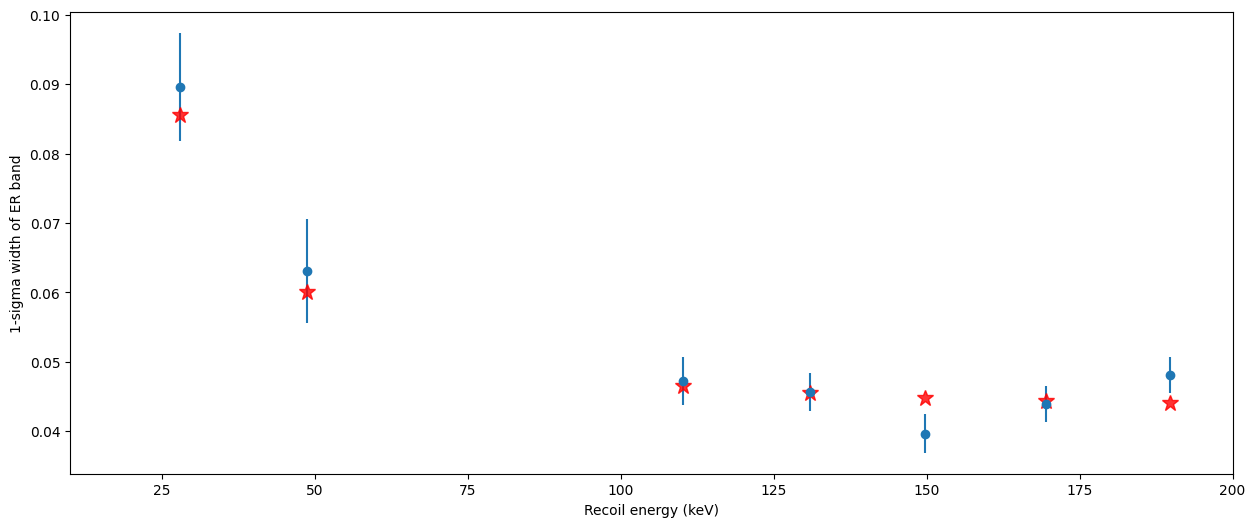

In [6]:
fig, axs = plt.subplots(1,1,figsize=(15,6))
# the ER-band fit
ax1 = axs

# note that np.log() is the natural log (base e)
FWHM_to_SIG = 1 / (2*np.sqrt(2*np.log(2)))
print(FWHM_to_SIG)

#get appropriate initial parameters
#get the resolutions for GGA3

aH=0.0381
V=4.0
C=0.0
sigHv,sigIv,sigQerv,sigH_NRv,sigI_NRv,sigQnrv = getEdw_det_res('GGA3',V,'data/edw_res_data.txt',aH,C,A=1.0,B=0.0)
sig0=np.sqrt(sigHv(0.0)**2+sigIv(0.0)**2)
bER = np.sqrt(sigHv(1.0)**2+sigIv(1.0)**2 - sig0**2)*(1/FWHM_to_SIG)
print(sig0,bER)



# plot the initial parameters
#sig0, F, bER= , 0.01731809, 0.0381
F = 0.0
V = 4.0
print ("log-likelihood: ", log_likelihood((F, bER, 1.0), ER_data, NR_data))

## get the ER prediction for the input parameters
model_ER = [np.sqrt(series_ERQ_var_gen(x,sig0=sig0,F=F,b=bER,V=4.0)) for x in ER_data['Erecoil']]


ax1.plot(ER_data['Erecoil'], model_ER, 'r*', alpha=0.8, markersize=12)


# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")


#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")

    
plt.xlim(10, 200)


In [7]:
# Final result: [3.80087771e-02, 3.22428020e-02, 1.23069856e-04, 9.99751973e-01, 1.49279368e-01, 1.78235616e-01]

# the number of function evaluations is about 560
if not fit_test:
    # start at about the minimum
    F,bER,scale = 0.1, 0.04280836346162822,1.0
 

    from scipy import optimize
    #np.random.seed(42)

    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([F, bER,scale]) #+ 0.001*np.random.randn(2)
    #soln = optimize.minimize(nll, initial, method='Nelder-Mead', args=(ER_data, NR_data), bounds=((sig0_min, sig0_max), (F_min, F_max), (bER_min, bER_max)), options={'xatol': 0.00001, 'fatol': 0.00001,'adaptive':True})
    soln = optimize.minimize(nll, initial, method='Powell', args=(ER_data, NR_data), bounds=((F_min, F_max), (bER_min, bER_max), (scale_min,scale_max)), options={'xtol': 0.00001, 'ftol': 0.00001})
    #print(soln)
    #soln = optimize.minimize(nll, initial, method='Nelder-Mead', args=(ER_data, NR_data), options={'adaptive':True})
    #aH_fit, C_fit, m_fit, scale_fit, A_fit, B_fit = soln.x
    
    #soln = optimize.brute(nll, ([0.0135, 0.018], [0.024, 0.048], [-0.0001, 0.0002], [0.9, 1.2], [0.06, 0.24], [0.06, 0.24]), args=(ER_data, NR_data))
    #soln = optimize.basinhopping(nll, initial, minimizer_kwargs={'args': (ER_data, NR_data)})
    #soln = optimize.shgo(nll, ([0.0,1.0],[bER_min, bER_max], [0.9, 1.2]), args=(ER_data, NR_data))
    #soln = optimize.shgo(nll, ([0.0,1.0],[bER_min, bER_max], [1.0, 1.0001]), args=(ER_data, NR_data))
    F_fit, bER_fit, scale_fit = soln.x

    with open('fit_results_ER_F_fixed_sig0.txt', 'w') as f:
        print (soln, file=f)
    print (soln)
    #print ("The number of function evaluations: ", soln.nfev)
    #print ("The number of function evaluations in local minima: ", soln.nlfev)
else:
    F_fit, bER_fit, scale_fit = np.array([0.00230675, 0.01731809, 1.05])

   direc: array([[-1.42037944e+00, -4.45360757e-04,  2.63719042e-02],
       [ 1.19939405e+00, -4.32460416e-04,  6.14875913e-03],
       [-2.54863800e-06, -3.90078255e-10,  3.73404540e-08]])
     fun: -29.591026682214522
 message: 'Optimization terminated successfully.'
    nfev: 437
     nit: 7
  status: 0
 success: True
       x: array([1.45855882e-11, 4.04408954e-02, 1.08253908e+00])


log-likelihood:  29.591026682214522


(0.035, 0.1)

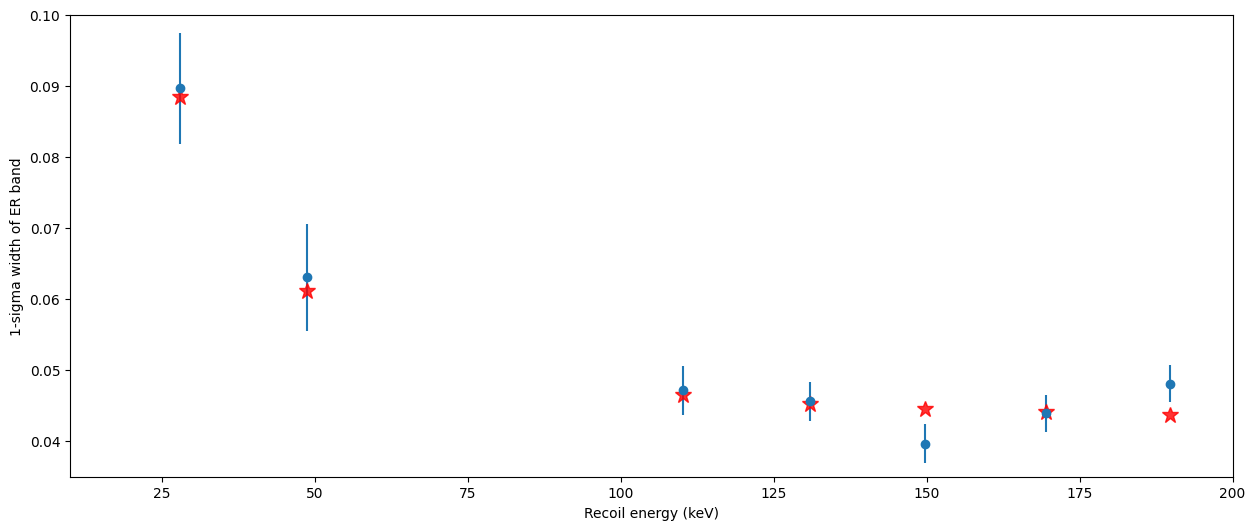

In [8]:
print ("log-likelihood: ", log_likelihood((F_fit,bER_fit,scale_fit), ER_data, NR_data))

fig, axs = plt.subplots(1,1,figsize=(15,6))
# the ER-band fit
ax1 = axs


# plot the best fit
# GGA3 parameters from Edelweiss tables
# all the parameters affect the points as expected
V_fit = 4.0

## get the ER prediction for the input parameters
## note that you should not use A_fit and B_fit for the ER model!
model_ER = [np.sqrt(series_ERQ_var_gen(x,sig0=sig0,F=F_fit,b=bER_fit,V=scale_fit*4.0)) for x in ER_data['Erecoil']]


ax1.plot(ER_data['Erecoil'], model_ER, 'r*', alpha=0.8, markersize=12)


# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")


#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")
    
plt.xlim(10, 200)
ax1.set_ylim(0.035, 0.1)

In [9]:
filename = 'data/edelweiss_ER_sampler_nll_EdwF_fixed_sig0.h5'

# random walks starting near the minimum
ndim, nwalkers = 3, 100
nburn = 500
nsteps = 5000
    
if not mcmc_test:
    pos0 = [[F_fit, bER_fit, scale_fit] + 1e-8*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(ER_data, NR_data))
    pos, prob, state = sampler.run_mcmc(pos0, nburn, storechain=False)
    sampler.reset()
    sampler.run_mcmc(pos, nsteps)
    samples = sampler.chain
    
else:
    f = h5py.File(filename,'r')

    # need to store data in an array:
    # The sampler will now have a chains attribute 
    # which is an array with shape (Nwalker,N,Ndim) 
    # where N is the number of interations (500 in our inital run)
    # and Ndim is the number of fit parameters
    path='{}/{}/'.format('mcmc','sampler')

    F = np.asarray(f[path+'F'])
    bER = np.asarray(f[path+'bER'])
    scale = np.asarray(f[path+'scale'])
    samples = np.asarray(f[path+'samples'])

    f.close()

/opt/anaconda3/envs/fano_pub_old_emcee/lib/python3.8/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0


In [10]:
import os.path

if not mcmc_test:
    #save the MCMC results
    path='{}/{}/'.format('mcmc','sampler')

    #remove vars
    f = h5py.File(filename,'a')
    exF = path+'F' in f
    exbER = path+'bER' in f
    exscale = path+'scale' in f
    exsamp = path+'samples' in f

    if exF:
      del f[path+'F']
    if exbER:
      del f[path+'bER']
    if exscale:
      del f[path+'scale']
    if exsamp:
      del f[path+'samples']

    dset = f.create_dataset(path+'F',np.shape(F_fit),dtype=np.dtype('float64').type)
    dset[...] = F_fit
    dset = f.create_dataset(path+'bER',np.shape(bER_fit),dtype=np.dtype('float64').type)
    dset[...] = bER_fit
    dset = f.create_dataset(path+'scale',np.shape(scale_fit),dtype=np.dtype('float64').type)
    dset[...] = scale_fit
    dset = f.create_dataset(path+'samples',np.shape(samples),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples

    f.close()

(100, 5000, 3)
(100, 5000)


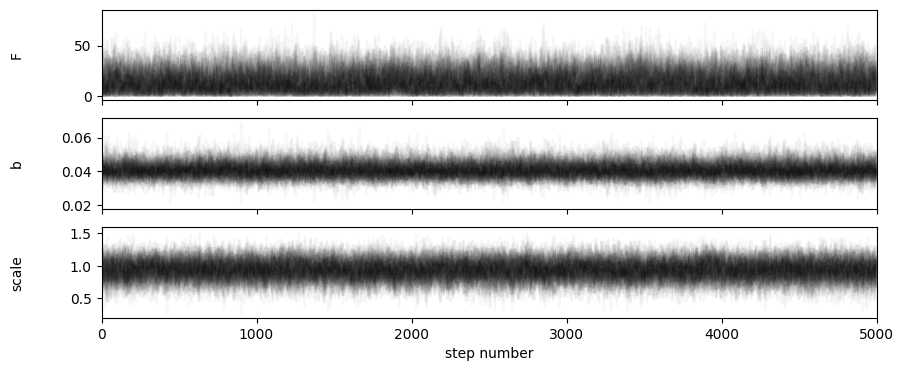

In [11]:
fig, axes = plt.subplots(ndim, figsize=(10, 4), sharex=True)

print (np.shape(samples))
print (np.shape(samples[:, :, 1]))
labels = ["F","b","scale"]
for i in range(ndim):
    ax = axes[i]
    # when you pass ax.plot a pair, the columns represent seperate data sets
    ax.plot(np.transpose(samples[:, :, i]), "k", alpha=0.03)
    ax.set_xlim(0, np.shape(samples)[1])
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(100, 5000, 3)
(470000, 3)


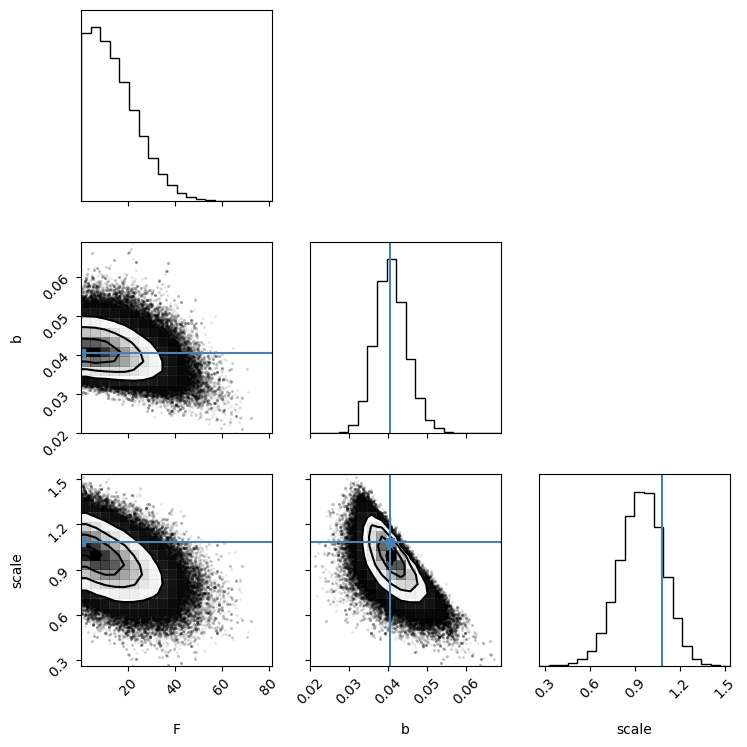

In [12]:
import corner
print(np.shape(samples))
samples_corner = samples[:, 300:, :].reshape((-1, ndim))
print(np.shape(samples_corner))
fig = corner.corner(samples_corner, labels=["F", "b", "scale"],
                      truths=[F_fit, bER_fit, scale_fit])


    
plt.tight_layout()
#plt.savefig('paper_figures/Corner_ERFano_EdwData.eps')
plt.savefig('paper_figures/Corner_ERFano_EdwData.pdf')
plt.show()

(100, 5000, 3)


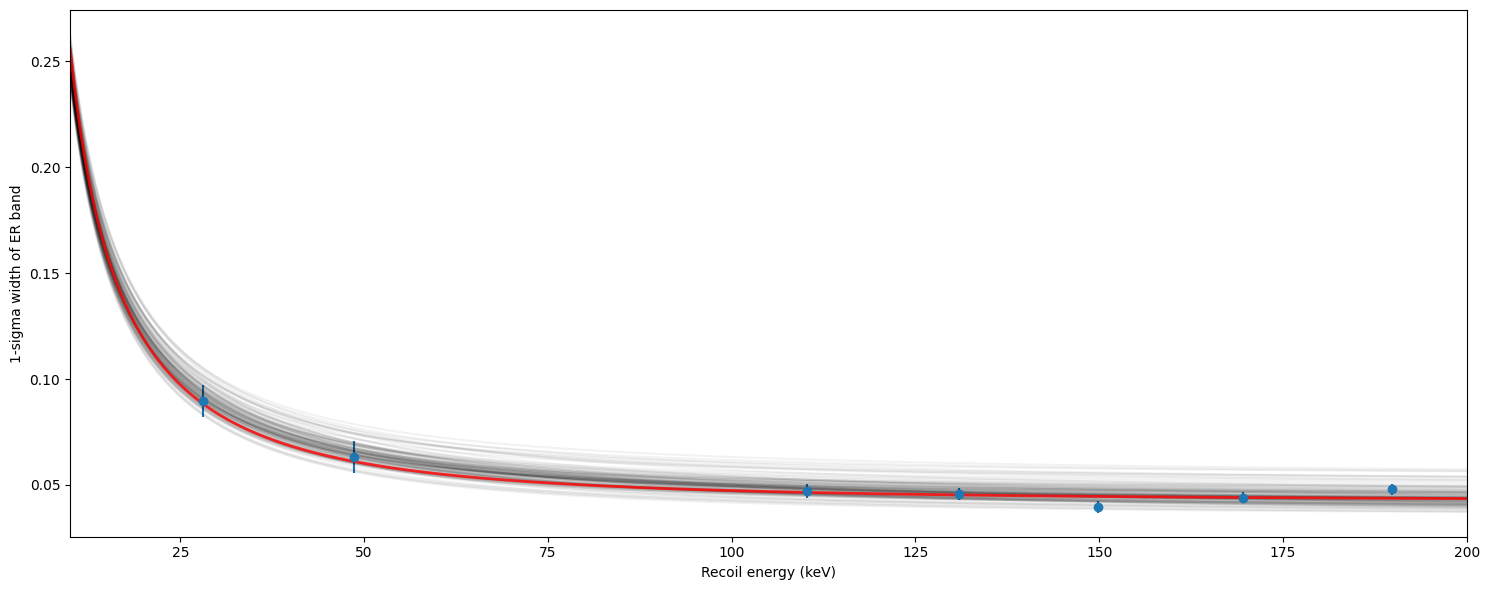

In [13]:
## View some fits

fig, axs = plt.subplots(1,1,figsize=(15,6))
# the ER-band fit
ax1 = axs


Erecoil = np.linspace(10, 200, 500)
print(np.shape(samples))
for F, bER,scale in samples_corner[np.random.randint(len(samples_corner), size=100)]:
    V = scale*4.0
    
    model_ER = [np.sqrt(series_ERQ_var_gen(x,sig0=sig0,F=F,b=bER,V=4.0)) for x in Erecoil]
    
    
    ax1.plot(Erecoil, model_ER, color="k", alpha=0.05)

# plot the best fit
V_fit = scale_fit*4.0
model_ER_fit = [np.sqrt(series_ERQ_var_gen(x,sig0=sig0,F=F_fit,b=bER_fit,V=V_fit)) for x in Erecoil]


ax1.plot(Erecoil, model_ER_fit, color="r", lw=2, alpha=0.8)


# plot the data
ax1.errorbar(ER_data['Erecoil'], ER_data['sigma'], yerr=ER_data['sigma_err'], fmt="o", label="data")


#ax1.plot(E_recoil_arr, sig_er_func(E_recoil_arr), label="Edelweiss ER resolution, C=0.0313")
ax1.set(xlabel="Recoil energy (keV)", ylabel="1-sigma width of ER band")

    
plt.xlim(10, 200)

plt.tight_layout()
#plt.savefig('paper_figures/Corner_ERFano_EdwData.eps')
plt.savefig('paper_figures/Fit_ERFano_EdwData.pdf')
plt.show()

In [14]:
filename = 'data/systematic_error_fits_corr_corrAB.h5'
if not do_sample_NR_test:
    sampsize=10000
    Erecoil_keV = np.linspace(10, 200, 50)
    evec = np.zeros((np.size(Erecoil_keV),sampsize))

    for i, (aH, C, m, scale, A, B) in enumerate(samples_corner[np.random.randint(len(samples_corner), size=sampsize)]):
        V = scale*4.0
        model_NR_0 = [series_NRQ_var_corr1(x, 0, V, aH, 1/18.0, A, B, 'GGA3') for x in Erecoil_keV] 
        model_NR = np.sqrt(np.power(C + m*Erecoil, 2) + model_NR_0)

        v = model_NR
        #print(np.std(v))
        #print(np.mean(v))
        evec[:,i] = v

    # use the best-fit function instead of the mean
    # to calculate the up and down limits:
    # find the height at which 68% of the function is contained
    # the upper and lower are the values that cross that height
    #upvec = #np.mean(evec,axis=1)+np.std(evec,axis=1)
    #dnvec = #np.mean(evec,axis=1)-np.std(evec,axis=1)
    upvec = []
    dnvec = []
    for sample in evec:
        #print (np.size(sample))
        #print(sample)
        interval = hpd(sample, 0.6827)
        #print (interval)
        upvec.append(interval[0])
        dnvec.append(interval[1])
        
    ## calculate the best-fit values
    model_NR_0 = [series_NRQ_var_corr1(x, 0, V_fit, aH_fit, 1/18.0, A_fit, B_fit, 'GGA3') for x in Erecoil_keV] 
    model_NR_fit = np.sqrt(np.power(C_fit + m_fit*Erecoil, 2) + model_NR_0)

else:
    f = h5py.File(filename,'r')
    path='{}/{}/'.format('mcmc','edwdata_sys_error')

    Erecoil_keV = np.asarray(f[path+'Er'])
    upvec = np.asarray(f[path+'Csig_u'])
    dnvec = np.asarray(f[path+'Csig_l'])
    model_NR_fit = np.asarray(f[path+'Sigss'])

    f.close()

ValueError: not enough values to unpack (expected 6, got 3)

In [ ]:
if not do_sample_NR_test:
    #save the results for the MS fit
    path='{}/{}/'.format('mcmc','edwdata_sys_error')

    #remove vars
    f = h5py.File(filename,'a')
    exaH = path+'aH' in f
    exCms = path+'Cms' in f
    exm = path+'m' in f
    exscale = path+'scale' in f
    exA = path+'A' in f
    exB = path+'B' in f
    exsamp = path+'samples' in f
    exsampsize = path+'sampsize' in f
    exEr = path+'Er' in f
    exCsig_u = path+'Csig_u' in f
    exCsig_l = path+'Csig_l' in f
    exSigss = path+'Sigss' in f

    if exaH:
      del f[path+'aH']
    if exCms:
      del f[path+'Cms']
    if exm:
      del f[path+'m']
    if exscale:
      del f[path+'scale']
    if exA:
      del f[path+'A']
    if exB:
      del f[path+'B']
    if exsamp:
      del f[path+'samples']
    if exsampsize:
      del f[path+'sampsize']
    if exEr:
      del f[path+'Er']
    if exCsig_u:
      del f[path+'Csig_u']
    if exCsig_l:
      del f[path+'Csig_l']
    if exSigss:
      del f[path+'Sigss']

    # save the fit parameters
    dset = f.create_dataset(path+'aH',np.shape(aH_fit),dtype=np.dtype('float64').type)
    dset[...] = aH_fit
    dset = f.create_dataset(path+'Cms',np.shape(C_fit),dtype=np.dtype('float64').type)
    dset[...] = C_fit
    dset = f.create_dataset(path+'m',np.shape(m_fit),dtype=np.dtype('float64').type)
    dset[...] = m_fit
    dset = f.create_dataset(path+'scale',np.shape(scale_fit),dtype=np.dtype('float64').type)
    dset[...] = scale_fit
    dset = f.create_dataset(path+'A',np.shape(A_fit),dtype=np.dtype('float64').type)
    dset[...] = A_fit
    dset = f.create_dataset(path+'B',np.shape(B_fit),dtype=np.dtype('float64').type)
    dset[...] = B_fit
    
    # save the MCMC samples
    dset = f.create_dataset(path+'samples',np.shape(samples_corner),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = samples_corner
    dset = f.create_dataset(path+'sampsize',np.shape(sampsize),dtype=np.dtype('float64').type)
    dset[...] = sampsize
    
    # save the with of the NR band
    dset = f.create_dataset(path+'Er',np.shape(Erecoil_keV),dtype=np.dtype('float64').type, \
    compression="gzip")
    dset[...] = Erecoil_keV
    dset = f.create_dataset(path+'Csig_u',np.shape(upvec),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = upvec
    dset = f.create_dataset(path+'Csig_l',np.shape(dnvec),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = dnvec
    dset = f.create_dataset(path+'Sigss',np.shape(Erecoil_keV),dtype=np.dtype('float64').type, \
    compression="gzip",compression_opts=9)
    dset[...] = model_NR_fit

    f.close()

In [ ]:
#plt.plot(Erecoil_keV, model_NR, color="r", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, model_NR_fit, color="r", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, upvec, color="r",linestyle="--", lw=2, alpha=0.8)
plt.plot(Erecoil_keV, dnvec, color="r",linestyle="--", lw=2, alpha=0.8)

plt.xlim(10, 200)
plt.ylim(0.03,0.12)
plt.errorbar(NR_data['Erecoil'], NR_data['sigma'], yerr=NR_data['sigma_err'], fmt="o", label="data", capsize=0)